In [1]:
import descartes
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import requests
import seaborn as sns

from arcgis.geocoding import geocode
from arcgis.gis import GIS
from dotenv import load_dotenv
from functools import reduce
from shapely.geometry import Point, Polygon
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.svm import SVC, SVR
from textwrap import wrap
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from yellowbrick.classifier import ROCAUC, ConfusionMatrix

%matplotlib inline
plt.style.use("ggplot")
sns.set_context("talk")

In [2]:
load_dotenv("")
censuskey = os.getenv("censuskey")

In [4]:
var_description = pd.DataFrame(pd.DataFrame(
    requests.get("https://api.census.gov/data/2017/acs/acs5/profile/variables.json")
                                            .json()["variables"])
                               .T.iloc[:, 3]
                               .str.title()
                               .str.replace("!!", " ", regex=True)
                               .str.replace("Percent Estimate ", " ", regex=True))
var_description.to_csv("data/var_description.csv")

In [5]:
variables = pd.DataFrame(requests.get(
    "https://api.census.gov/data/2017/acs/acs5/profile/variables.json").json()["variables"].keys(),
                         columns=["index_name"])

In [6]:
variables_selected = variables.loc[((~variables.index_name.str.contains(r'DP')|
                                     (variables.index_name.str.contains(r'DP')&
                                      variables.index_name.str.contains(r'[0-9]PE')))&
                                    ~variables.index_name.str.contains(r'PR_'))]

In [7]:
resp = requests.get(
    "https://api.census.gov/data/2017/acs/acs5/profile?get=NAME&for=county:*&in=state:*&key={}"
    .format(censuskey))

In [8]:
county = pd.DataFrame(resp.json()[1:], columns=resp.json()[0])

In [9]:
varlist = []
for var in variables_selected.index_name:
    resp = requests.get(
        "https://api.census.gov/data/2017/acs/acs5/profile?get={}&for=county:*&in=state:*&key={}"
        .format(var, censuskey))
    if resp.status_code ==200:
        varlist.append(pd.DataFrame(resp.json()[1:], columns=resp.json()[0]))

In [10]:
df_merged = reduce(lambda left, right: pd.merge(left, right, how='outer'), varlist)

In [11]:
df_merged.dropna(axis=1, inplace=True)

In [12]:
df_merged.head()

,DP05_0050PE,state,county,DP04_0016PE,DP03_0048PE,DP04_0029PE,DP03_0022PE,DP04_0003PE,DP03_0111PE,DP04_0136PE,...,DP05_0054PE,DP04_0051PE,DP03_0026PE,DP05_0041PE,DP04_0082PE,DP04_0105PE,DP03_0115PE,GEOCOMP,DP03_0039PE,DP04_0095PE
0,0.0,01,107,9538,18.1,0.9,1.6,20.1,16.3,1443,...,0.0,4.7,6903,0.0,31.7,19.7,89.6,00,0.8,47.3
1,0.0,01,119,6833,23.6,3.2,3.1,25.8,10.3,1354,...,0.0,8.0,4353,0.0,32.5,19.1,70.6,00,1.1,56.6
2,0.3,01,073,306110,13.5,1.4,1.4,14.6,37.9,88248,...,0.0,11.1,300739,0.0,23.1,30.7,83.7,00,2.3,27.0
3,0.0,01,023,7329,14.8,0.5,1.7,25.5,24.7,783,...,0.0,5.7,4301,0.0,29.0,26.1,82.9,00,1.6,49.8
4,0.0,01,059,14132,15.6,1.5,0.2,18.4,30.9,2798,...,0.0,8.1,12534,0.0,36.0,23.8,76.0,00,2.7,59.2


In [13]:
df_clean = pd.concat([df_merged.loc[:, ~df_merged.columns.str.contains(r'[0-9]PE')].
                    drop(columns=["STATE", "COUNTY"]),
                    df_merged.loc[:, df_merged.columns.str.contains(r'[0-9]PE')]
                    .loc[:, ((df_merged.loc[:, df_merged.columns.str.contains(r'[0-9]PE')].max()<100)&
                             (df_merged.loc[:, df_merged.columns.str.contains(r'[0-9]PE')].min()>=0))]],
                     axis=1
                   )

In [16]:
df_clean.head()

,NAME,state,county,GEO_ID,GEOCOMP,DP05_0050PE,DP03_0048PE,DP04_0029PE,DP03_0022PE,DP04_0003PE,...,DP04_0140PE,DP05_0010PE,DP04_0118PE,DP05_0054PE,DP04_0051PE,DP05_0041PE,DP04_0082PE,DP04_0105PE,DP03_0115PE,DP03_0039PE
0,"Pickens County, Alabama",01,107,0500000US01107,00,0.0,18.1,0.9,1.6,20.1,...,12.8,12.6,43.9,0.0,4.7,0.0,31.7,19.7,89.6,0.8
1,"Sumter County, Alabama",01,119,0500000US01119,00,0.0,23.6,3.2,3.1,25.8,...,4.9,11.3,38.4,0.0,8.0,0.0,32.5,19.1,70.6,1.1
2,"Jefferson County, Alabama",01,073,0500000US01073,00,0.3,13.5,1.4,1.4,14.6,...,11.4,14.4,47.6,0.0,11.1,0.0,23.1,30.7,83.7,2.3
3,"Choctaw County, Alabama",01,023,0500000US01023,00,0.0,14.8,0.5,1.7,25.5,...,9.3,9.9,38.4,0.0,5.7,0.0,29.0,26.1,82.9,1.6
4,"Franklin County, Alabama",01,059,0500000US01059,00,0.0,15.6,1.5,0.2,18.4,...,9.1,12.1,43.1,0.0,8.1,0.0,36.0,23.8,76.0,2.7


In [15]:
df_clean = pd.merge(county, df_clean, on = ["state", "county"])

In [17]:
df_clean.county = df_clean.NAME.str.split(',', expand=True).loc[:, 0]
df_clean.state = df_clean.NAME.str.split(',', expand=True).loc[:, 1].map(
    lambda x: x.lstrip(" "))
df_clean["FIPS5"] = df_clean.GEO_ID.apply(lambda x: int(str(x)[-5:]))
df_clean.head()

,NAME,state,county,GEO_ID,GEOCOMP,DP05_0050PE,DP03_0048PE,DP04_0029PE,DP03_0022PE,DP04_0003PE,...,DP05_0010PE,DP04_0118PE,DP05_0054PE,DP04_0051PE,DP05_0041PE,DP04_0082PE,DP04_0105PE,DP03_0115PE,DP03_0039PE,FIPS5
0,"Pickens County, Alabama",Alabama,Pickens County,0500000US01107,00,0.0,18.1,0.9,1.6,20.1,...,12.6,43.9,0.0,4.7,0.0,31.7,19.7,89.6,0.8,1107
1,"Sumter County, Alabama",Alabama,Sumter County,0500000US01119,00,0.0,23.6,3.2,3.1,25.8,...,11.3,38.4,0.0,8.0,0.0,32.5,19.1,70.6,1.1,1119
2,"Jefferson County, Alabama",Alabama,Jefferson County,0500000US01073,00,0.3,13.5,1.4,1.4,14.6,...,14.4,47.6,0.0,11.1,0.0,23.1,30.7,83.7,2.3,1073
3,"Choctaw County, Alabama",Alabama,Choctaw County,0500000US01023,00,0.0,14.8,0.5,1.7,25.5,...,9.9,38.4,0.0,5.7,0.0,29.0,26.1,82.9,1.6,1023
4,"Franklin County, Alabama",Alabama,Franklin County,0500000US01059,00,0.0,15.6,1.5,0.2,18.4,...,12.1,43.1,0.0,8.1,0.0,36.0,23.8,76.0,2.7,1059


In [21]:
election = pd.read_csv("data/countypres_2000-2016.csv")

In [22]:
election.dropna(inplace=True)

In [23]:
election["candidateshare"] = election.candidatevotes / election.totalvotes
hillary = election.loc[((election.year==2016)&(election.candidate=="Hillary Clinton"))]
hillary = hillary[["state", "county", "candidateshare", "FIPS"]]
hillary.rename(columns={"candidateshare":"hillary"}, inplace=True)
trump = election.loc[((election.year==2016)&(election.candidate=="Donald Trump"))]
trump = trump[["state", "county", "candidateshare", "FIPS"]]
trump.rename(columns={"candidateshare":"trump"}, inplace=True)

In [24]:
election_result = pd.merge(hillary, trump, on=["state", "county", "FIPS"])

In [25]:
election_result["target"] = (election_result.trump > election_result.hillary)*1
election_result.FIPS = election_result.FIPS.astype(int)
election_result.head()

,state,county,hillary,FIPS,trump,target
0,Alabama,Autauga,0.237697,1001,0.727666,1
1,Alabama,Baldwin,0.193856,1003,0.765457,1
2,Alabama,Barbour,0.465278,1005,0.520967,1
3,Alabama,Bibb,0.212496,1007,0.764032,1
4,Alabama,Blount,0.084258,1009,0.893348,1


In [26]:
election_result.describe()

,hillary,FIPS,trump,target
count,3153.000000,3153.000000,3153.000000,3153.000000
mean,0.316270,30299.052331,0.630576,0.840469
std,0.152591,15211.976727,0.157801,0.366228
min,0.031447,1001.000000,0.040875,0.000000
25%,0.203935,18163.000000,0.541485,1.000000
50%,0.284064,29167.000000,0.662323,1.000000
75%,0.401236,45075.000000,0.747975,1.000000
max,0.908638,56045.000000,0.960334,1.000000


In [31]:
df = pd.merge(df_clean, 
              election_result.drop(columns=["state", "county"]), 
              left_on="FIPS5",
              right_on="FIPS",
              how="inner").apply(pd.to_numeric, errors="ignore")
df.drop(columns=["FIPS5"], inplace=True)
df.rename(columns={"FIPS_x":"FIPS"}, inplace=True)
df.head()

,NAME,state,county,GEO_ID,GEOCOMP,DP05_0050PE,DP03_0048PE,DP04_0029PE,DP03_0022PE,DP04_0003PE,...,DP04_0051PE,DP05_0041PE,DP04_0082PE,DP04_0105PE,DP03_0115PE,DP03_0039PE,hillary,FIPS,trump,target
0,"Pickens County, Alabama",Alabama,Pickens County,0500000US01107,0,0.0,18.1,0.9,1.6,20.1,...,4.7,0.0,31.7,19.7,89.6,0.8,0.416265,1107,0.571788,1
1,"Sumter County, Alabama",Alabama,Sumter County,0500000US01119,0,0.0,23.6,3.2,3.1,25.8,...,8.0,0.0,32.5,19.1,70.6,1.1,0.740290,1119,0.246607,0
2,"Jefferson County, Alabama",Alabama,Jefferson County,0500000US01073,0,0.3,13.5,1.4,1.4,14.6,...,11.1,0.0,23.1,30.7,83.7,2.3,0.515706,1073,0.443037,0
3,"Choctaw County, Alabama",Alabama,Choctaw County,0500000US01023,0,0.0,14.8,0.5,1.7,25.5,...,5.7,0.0,29.0,26.1,82.9,1.6,0.426358,1023,0.563083,1
4,"Franklin County, Alabama",Alabama,Franklin County,0500000US01059,0,0.0,15.6,1.5,0.2,18.4,...,8.1,0.0,36.0,23.8,76.0,2.7,0.182475,1059,0.786213,1


In [32]:
df.to_csv("data/election_census_final.csv")

In [85]:
X = df.iloc[:, 3:-4]
y = df.target

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

In [88]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.iloc[:, 2:])
X_test_scaled = scaler.transform(X_test.iloc[:, 2:])

In [89]:
rfc = RandomForestClassifier(class_weight="balanced")
rfc.fit(X_train_scaled, y_train)
print("train: ", rfc.score(X_train_scaled, y_train))
print("test: ", rfc.score(X_test_scaled, y_test))

train:  0.9961423060437206
test:  0.9267352185089974


/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [90]:
rfc_features = pd.merge(pd.DataFrame(rfc.feature_importances_, 
                                     index=X.iloc[:, 2:].columns, 
                                     columns=["importance"]
                                    ).sort_values(by="importance", ascending=False),
                        var_description, 
                        how="left",
                        right_index=True, 
                        left_index=True)

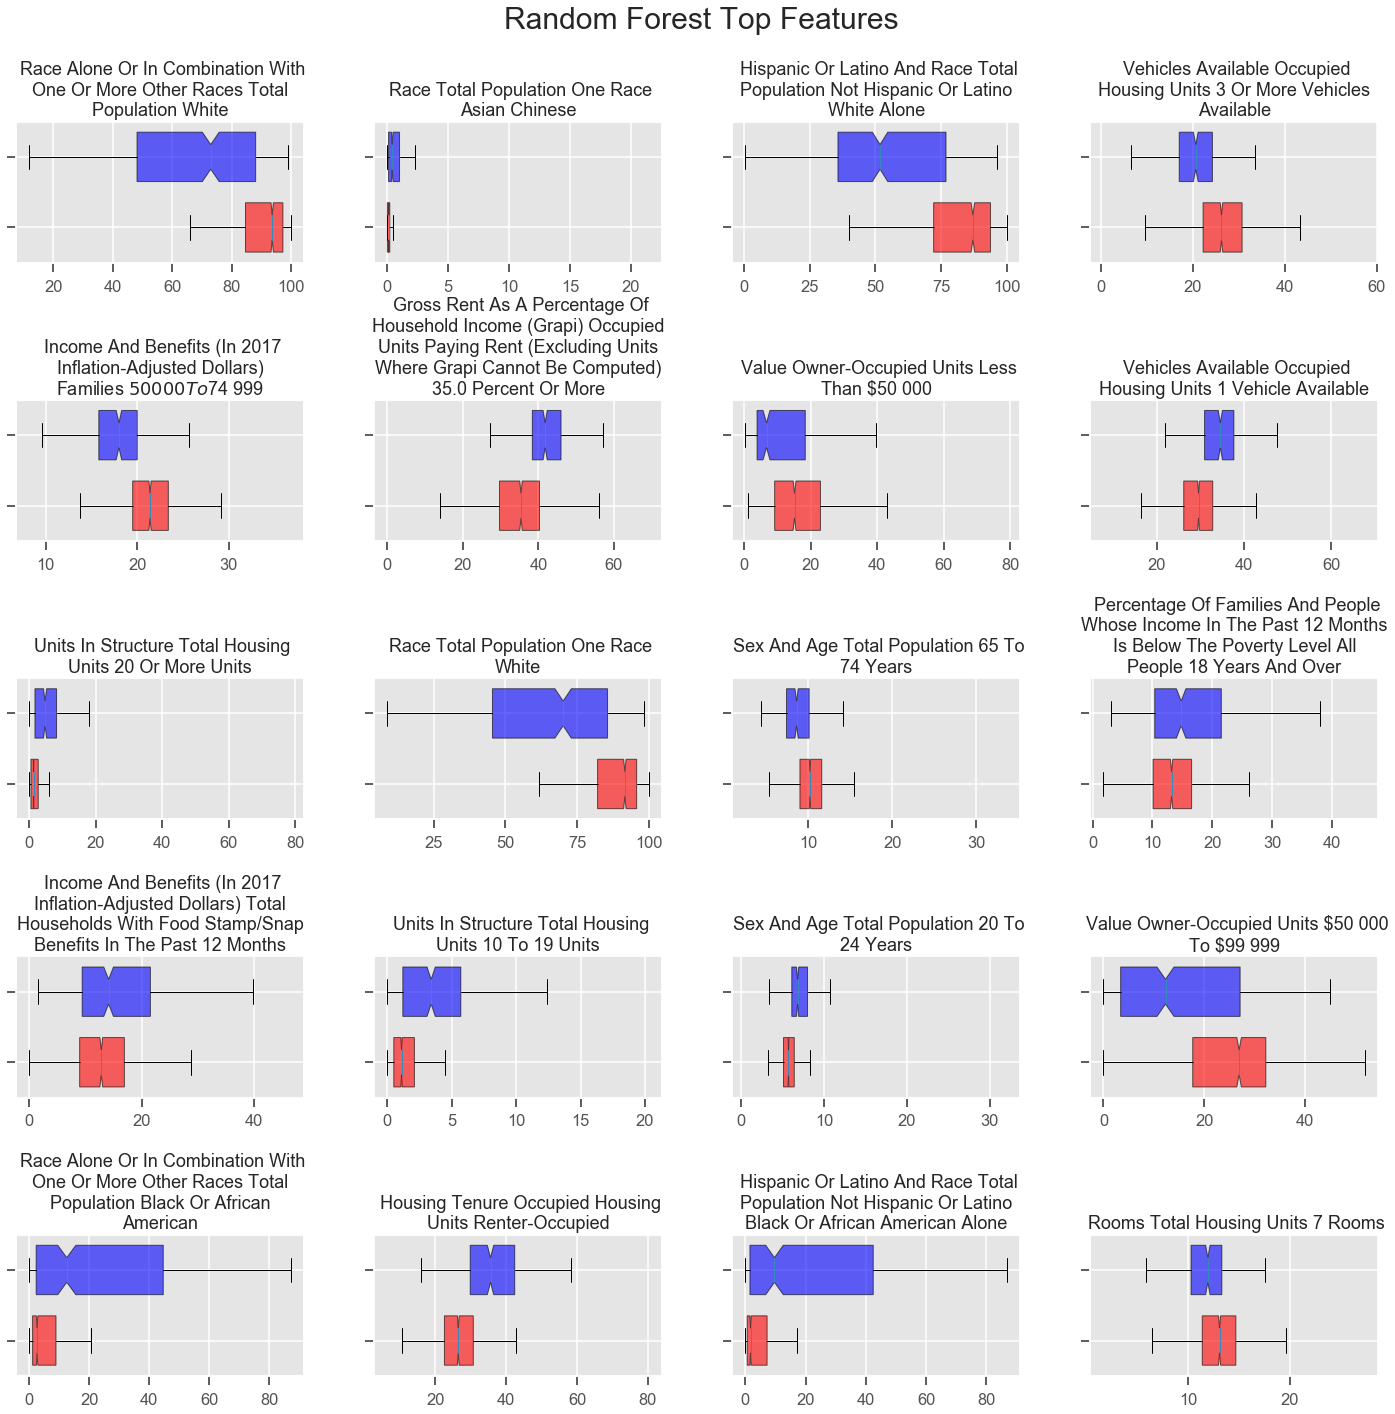

In [91]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
fig.suptitle("Random Forest Top Features", fontsize=30)
for i in range(20):
    bp = ax[i//4, i%4].boxplot([X.loc[y==1, rfc_features.index[i]], X.loc[y==0, rfc_features.index[i]]],
                               vert=False,
                               labels=["T", "H"],
                               notch=True, 
                               patch_artist=True,
                               widths=0.7
                              )
    for patch, color in zip(bp['boxes'], ["red", "blue"]):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

#     ax[i//4, i%4].set_xticklabels([])
    ax[i//4, i%4].set_yticklabels([])
    ax[i//4, i%4].set_title("\n".join(wrap(rfc_features.label[i], 35)),
                            fontsize=18
                           )
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.savefig("images/rfc_features_box")
plt.show()

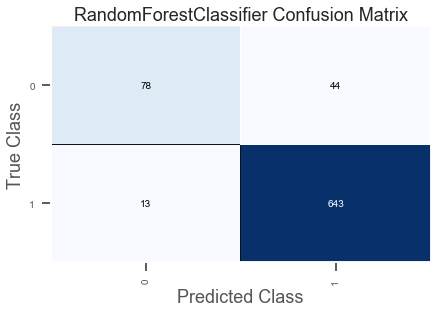

In [92]:
cm = ConfusionMatrix(rfc, 
                     classes=[0, 1],
#                      label_encoder={0: "Hillary", 1: "Trump"},
                     cmap="Blues"
                    )

cm.score(X_test_scaled, y_test)
plt.tight_layout()
cm.poof(outpath="images/cm_rfc")

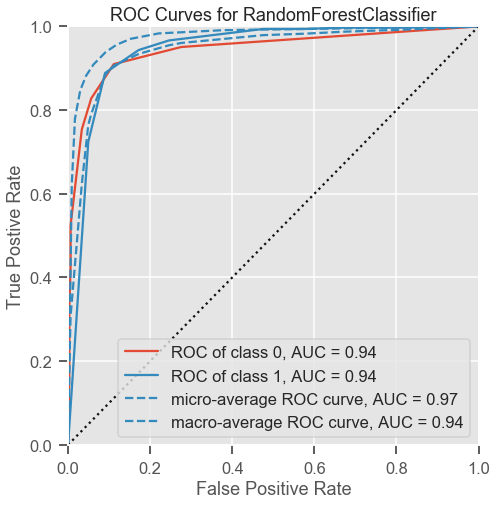

In [93]:
visualizer = ROCAUC(rfc, 
                    classes=[0, 1],
                    size=(480, 480)
                   )

visualizer.score(X_test_scaled, y_test) 
plt.tight_layout()
g = visualizer.poof(outpath="images/ROC_rfc")

In [94]:
svc = SVC(probability=True, kernel="linear")
svc.fit(X_train_scaled, y_train)
print("train: ", svc.score(X_train_scaled, y_train))
print("test: ", svc.score(X_test_scaled, y_test))

train:  0.9811401628804115
test:  0.922879177377892


In [95]:
svc_features = pd.merge(pd.DataFrame(svc.coef_.T, 
             index=X.iloc[:, 2:].columns, 
             columns=["importance"]
            ).apply(lambda x: np.abs(x)).
                        sort_values(by="importance", ascending=False),
                        var_description, 
                        how="left",
                        right_index=True, left_index=True)

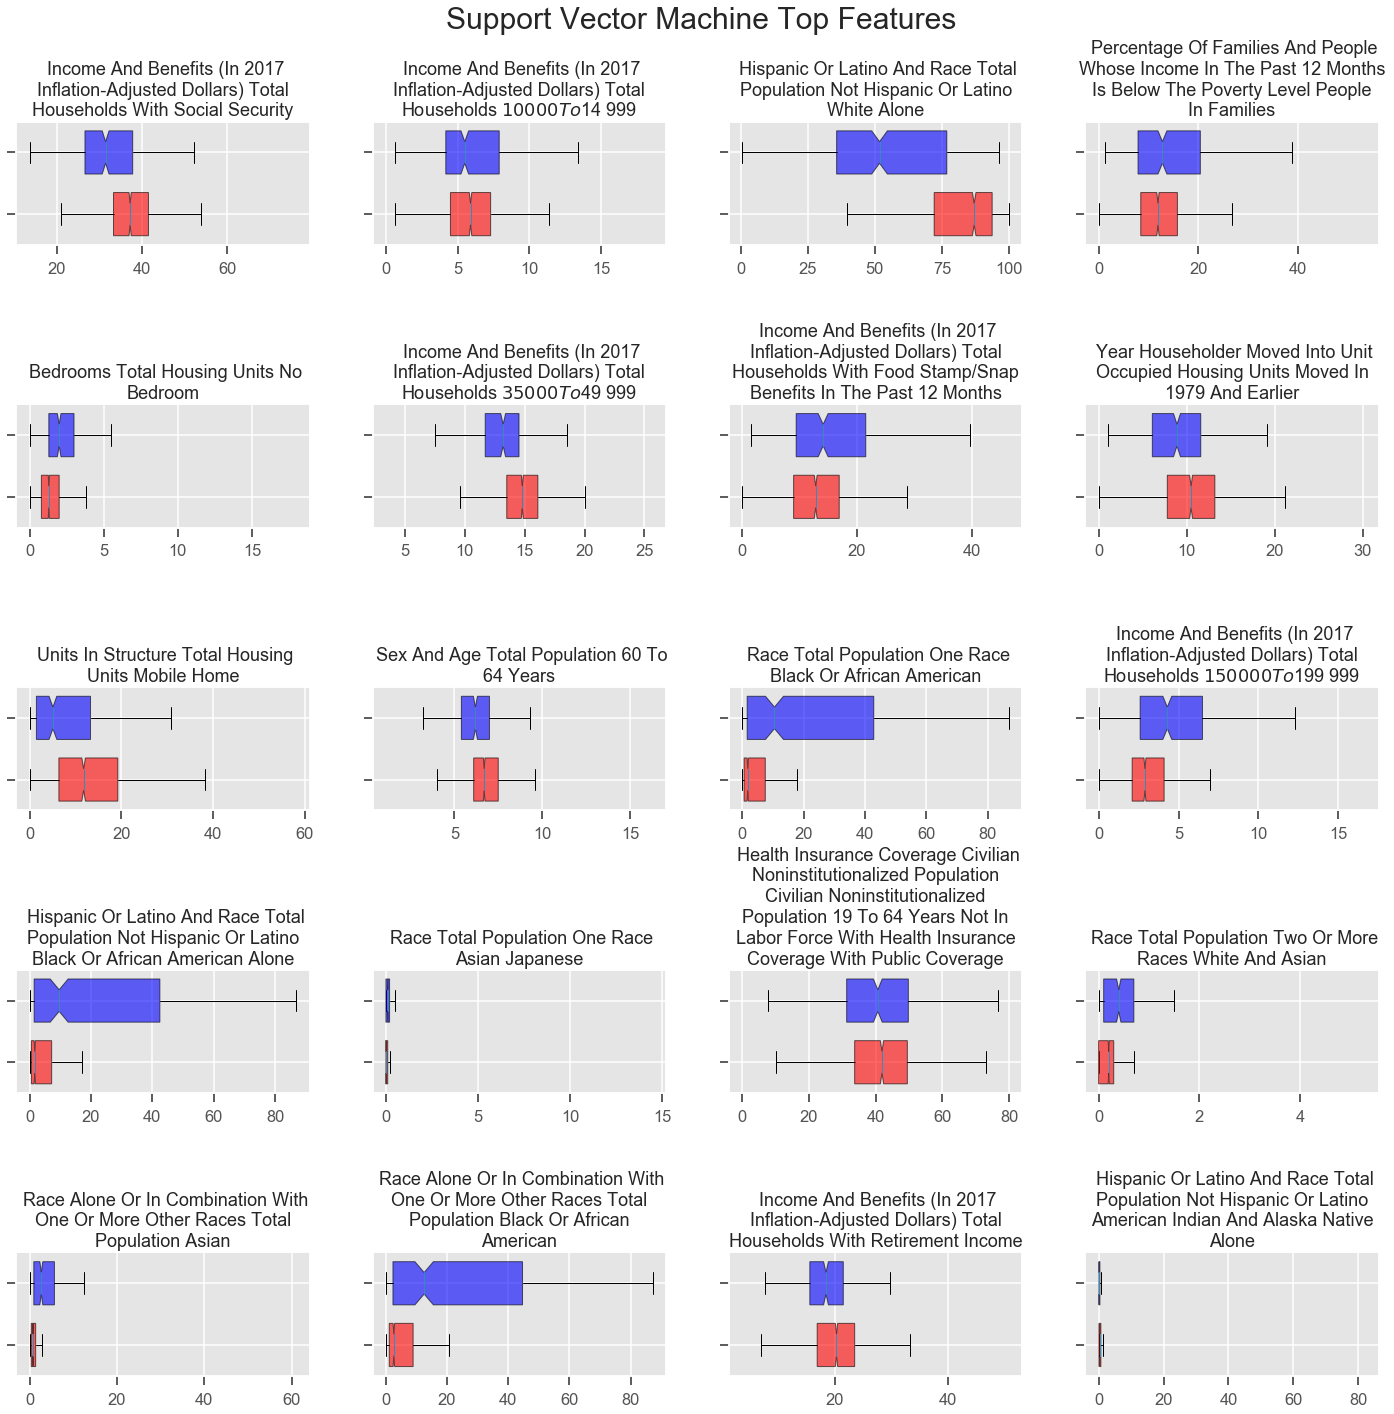

In [96]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
fig.suptitle("Support Vector Machine Top Features", fontsize=30)
for i in range(20):
    bp = ax[i//4, i%4].boxplot([X.loc[y==1, svc_features.index[i]], X.loc[y==0, svc_features.index[i]]],
                               vert=False,
                               labels=["T", "H"],
                               notch=True, 
                               patch_artist=True,
                               widths=0.7
                              )
    for patch, color in zip(bp['boxes'], ["red", "blue"]):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

#     ax[i//4, i%4].set_xticklabels([])
    ax[i//4, i%4].set_yticklabels([])
    ax[i//4, i%4].set_title("\n".join(wrap(svc_features.label[i], 35)),
                            fontsize=18
                           )
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.savefig("images/svc_features_box")
plt.show()

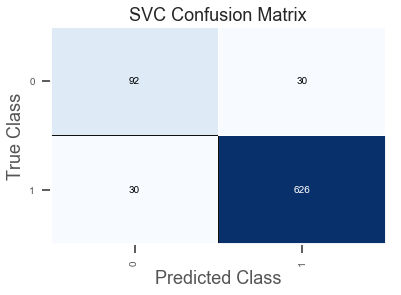

In [97]:
cm = ConfusionMatrix(svc, 
                     classes=[0, 1],
#                      label_encoder={0: "Hillary", 1: "Trump"},
                     cmap="Blues"
                    )

cm.score(X_test_scaled, y_test)
cm.poof(outpath="images/cm_svc")

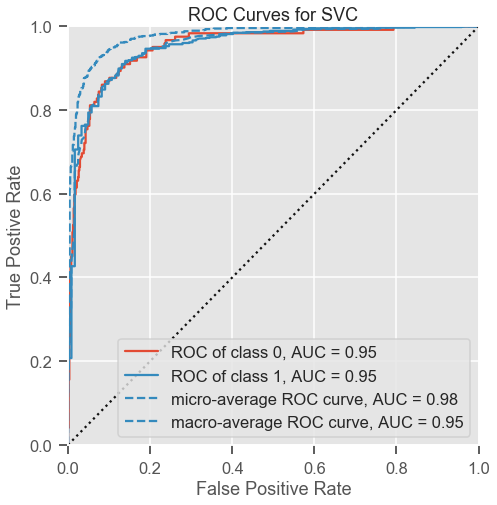

In [98]:
visualizer = ROCAUC(svc, 
                    classes=[0, 1],
                    size=(480,480)
                   )

visualizer.score(X_test_scaled, y_test) 
plt.tight_layout()
g = visualizer.poof(outpath="images/ROC_svc")

In [99]:
xgc = XGBClassifier()
xgc.fit(X_train_scaled, y_train)
print("train: ", xgc.score(X_train_scaled, y_train))
print("test: ", xgc.score(X_test_scaled, y_test))

train:  0.9918559794256322
test:  0.9550128534704371


In [100]:
xgc_features = pd.merge(pd.DataFrame(xgc.feature_importances_, 
             index=X.iloc[:, 2:].columns, 
             columns=["importance"]
            ).sort_values(by="importance", ascending=False), var_description, how="left",
                        right_index=True, left_index=True)

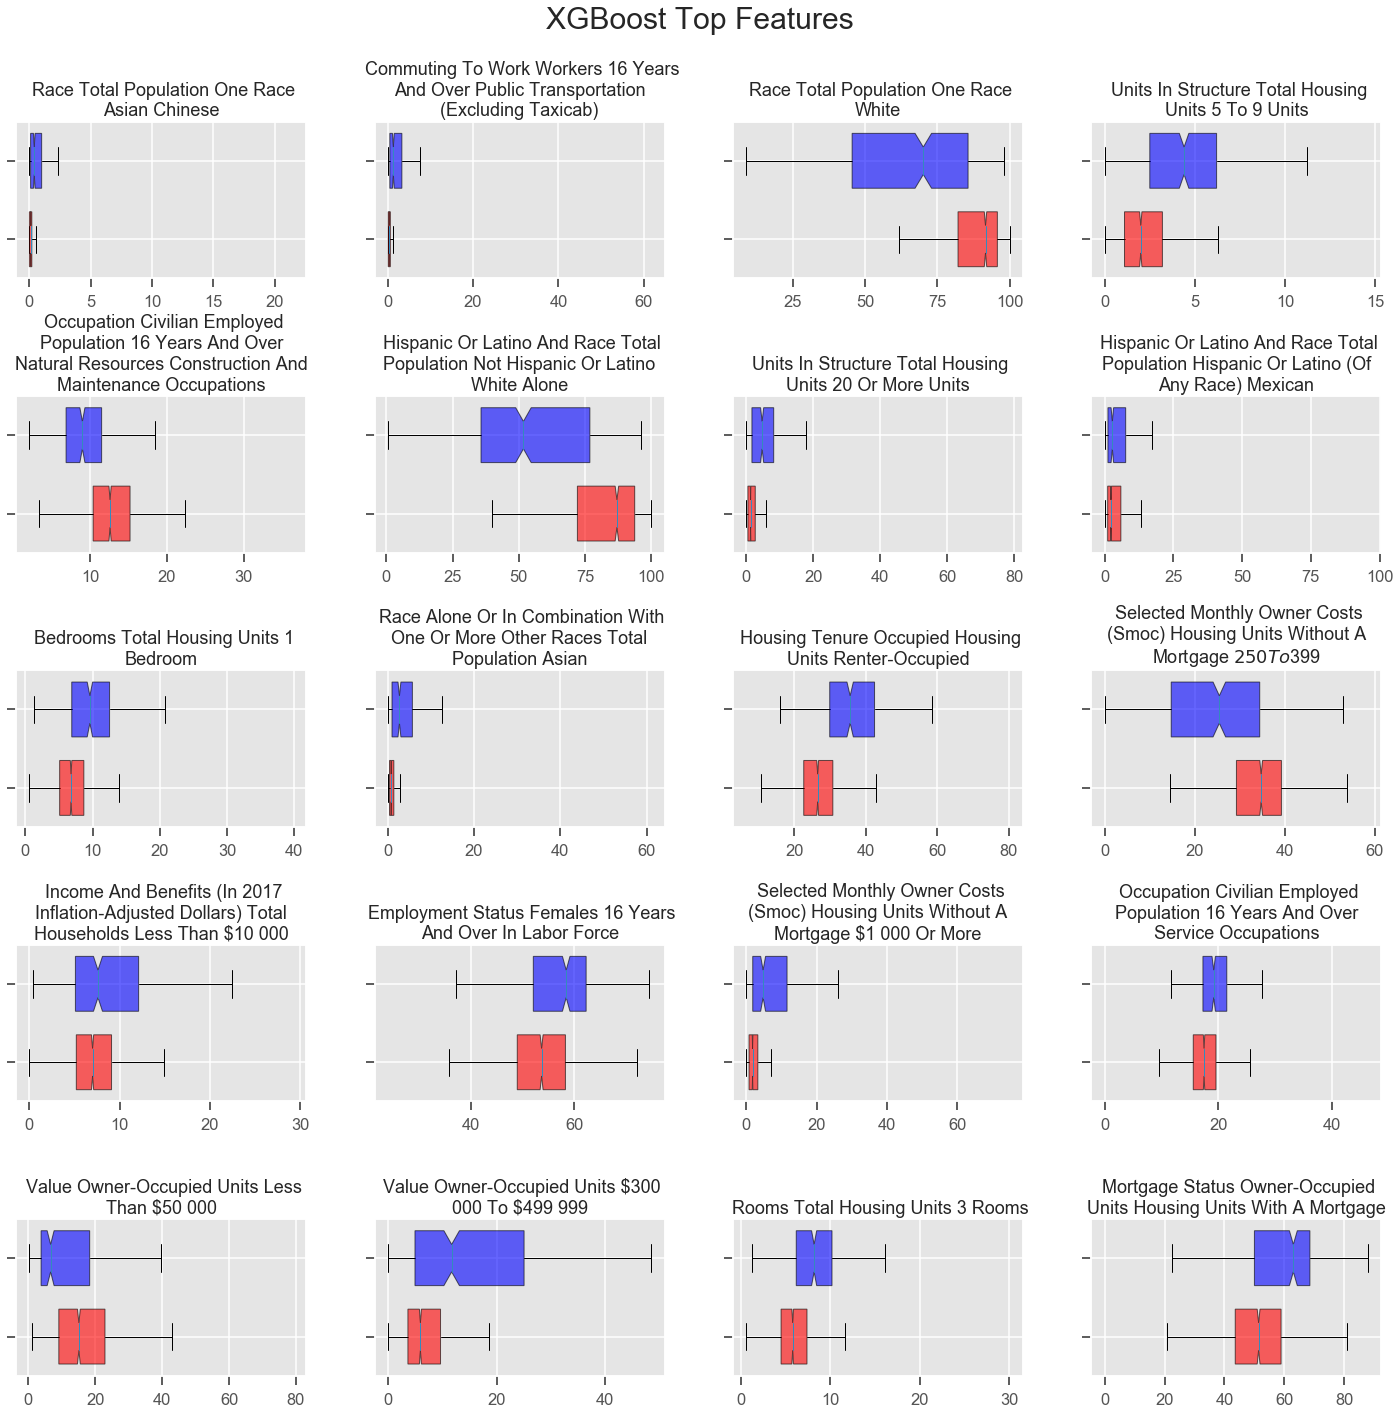

In [101]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
fig.suptitle("XGBoost Top Features", fontsize=30)
for i in range(20):
    bp = ax[i//4, i%4].boxplot([X.loc[y==1, xgc_features.index[i]], X.loc[y==0, xgc_features.index[i]]],
                               vert=False,
                               labels=["T", "H"],
                               notch=True, 
                               patch_artist=True,
                               widths=0.7
                              )
    for patch, color in zip(bp['boxes'], ["red", "blue"]):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

#     ax[i//4, i%4].set_xticklabels([])
    ax[i//4, i%4].set_yticklabels([])
    ax[i//4, i%4].set_title("\n".join(wrap(xgc_features.label[i], 35)),
                            fontsize=18
                           )
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.savefig("images/xgc_features_box")
plt.show()

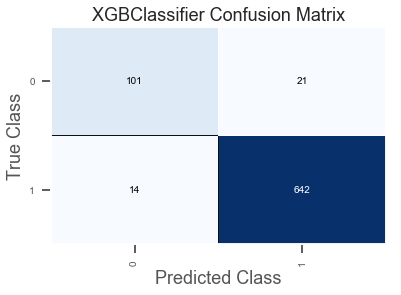

In [102]:
cm = ConfusionMatrix(xgc, 
                     classes=[0, 1],
#                      label_encoder={0: "Hillary", 1: "Trump"},
                     cmap="Blues"
                    )

cm.score(X_test_scaled, y_test)
cm.poof(outpath="images/cm_xgc")

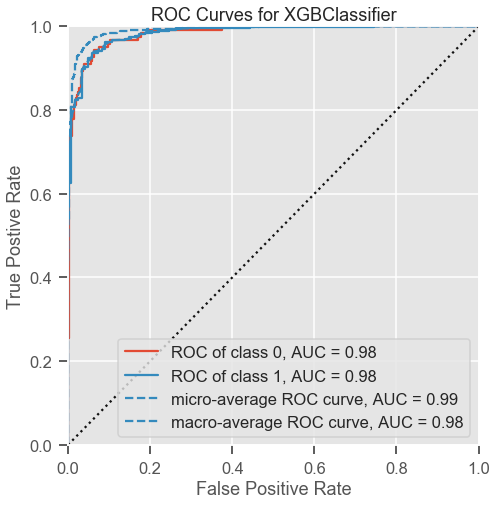

In [103]:
visualizer = ROCAUC(xgc, 
                    classes=[0, 1],
                    size=(480,480)
                   )

visualizer.score(X_test_scaled, y_test) 
plt.tight_layout()
g = visualizer.poof(outpath="images/ROC_xgc")

In [105]:
xgc_scores = {}
xgc_feature_sets = []
k=0
for i in range(0, 500, 10):
    for j in range(0, 100, 10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train.iloc[:, 2:])
        X_test_scaled = scaler.transform(X_test.iloc[:, 2:])
        xgc = XGBClassifier(reg_alpha=i, reg_lambda=j)
        xgc.fit(X_train_scaled, y_train)

        
        xgc_features = pd.merge(pd.DataFrame(xgc.feature_importances_, 
                                             index=X.iloc[:, 2:].columns,
                                             columns=["importance"]
                                            ).sort_values(by="importance", 
                                                          ascending=False), 
                                var_description, 
                                how="left",
                                right_index=True, 
                                left_index=True)
        xgc_scores[k] = [i,
                         j,
                         xgc.score(X_train_scaled, y_train),
                         xgc.score(X_test_scaled, y_test),
                         np.sum(xgc_features.importance>0)]
        xgc_feature_sets.append(xgc_features)
        k += 1

In [106]:
xgc_reg_score = pd.DataFrame(xgc_scores, 
                             index=["alpha",
                                    "lambda",
                                    "train",
                                    "test",
                                    "n_features"
                                   ]).T

In [114]:
xgc_reg_score.loc[xgc_reg_score.n_features<=10].sort_values(by="test", ascending=False).head(20)

,alpha,lambda,train,test,n_features
395,390.0,50.0,0.927561,0.940874,10.0
332,330.0,20.0,0.931419,0.938303,10.0
478,470.0,80.0,0.928847,0.937018,10.0
457,450.0,70.0,0.930990,0.935733,10.0
465,460.0,50.0,0.926704,0.934447,8.0
440,440.0,0.0,0.924132,0.934447,8.0
323,320.0,30.0,0.930133,0.934447,10.0
432,430.0,20.0,0.925847,0.934447,8.0
439,430.0,90.0,0.925847,0.933162,9.0
481,480.0,10.0,0.928418,0.933162,10.0


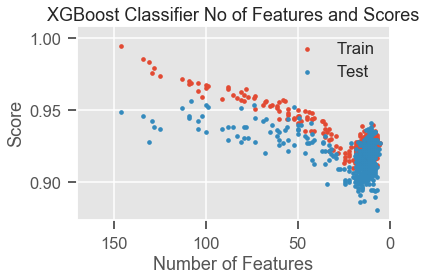

In [108]:
plt.scatter(xgc_reg_score.n_features, 
            xgc_reg_score.train,
            s=10
           )
plt.scatter(xgc_reg_score.n_features,
            xgc_reg_score.test,
            s=10
           )
plt.title("XGBoost Classifier No of Features and Scores")
plt.ylabel("Score")
plt.xlabel("Number of Features")
plt.xlim(170, 0)
plt.legend(["Train","Test"])
plt.tight_layout()
plt.savefig("images/xgc_reg_score")

In [119]:
xgc_feature_sets[
    xgc_reg_score.loc[
        xgc_reg_score.n_features<=10].sort_values(
        by="test", 
        ascending=False
    ).index[0]].iloc[:10]

,importance,label
DP03_0021PE,0.238204,Commuting To Work Workers 16 Years And Over P...
DP05_0077PE,0.197676,Hispanic Or Latino And Race Total Population ...
DP05_0037PE,0.123308,Race Total Population One Race White
DP05_0065PE,0.104879,Race Alone Or In Combination With One Or More...
DP05_0046PE,0.089382,Race Total Population One Race Asian Chinese
DP04_0104PE,0.063347,Selected Monthly Owner Costs (Smoc) Housing U...
DP04_0066PE,0.063168,House Heating Fuel Occupied Housing Units Fue...
DP03_0030PE,0.055406,Occupation Civilian Employed Population 16 Ye...
DP04_0010PE,0.041004,Units In Structure Total Housing Units 3 Or 4...
DP04_0087PE,0.023626,Value Owner-Occupied Units $500 000 To $999 999


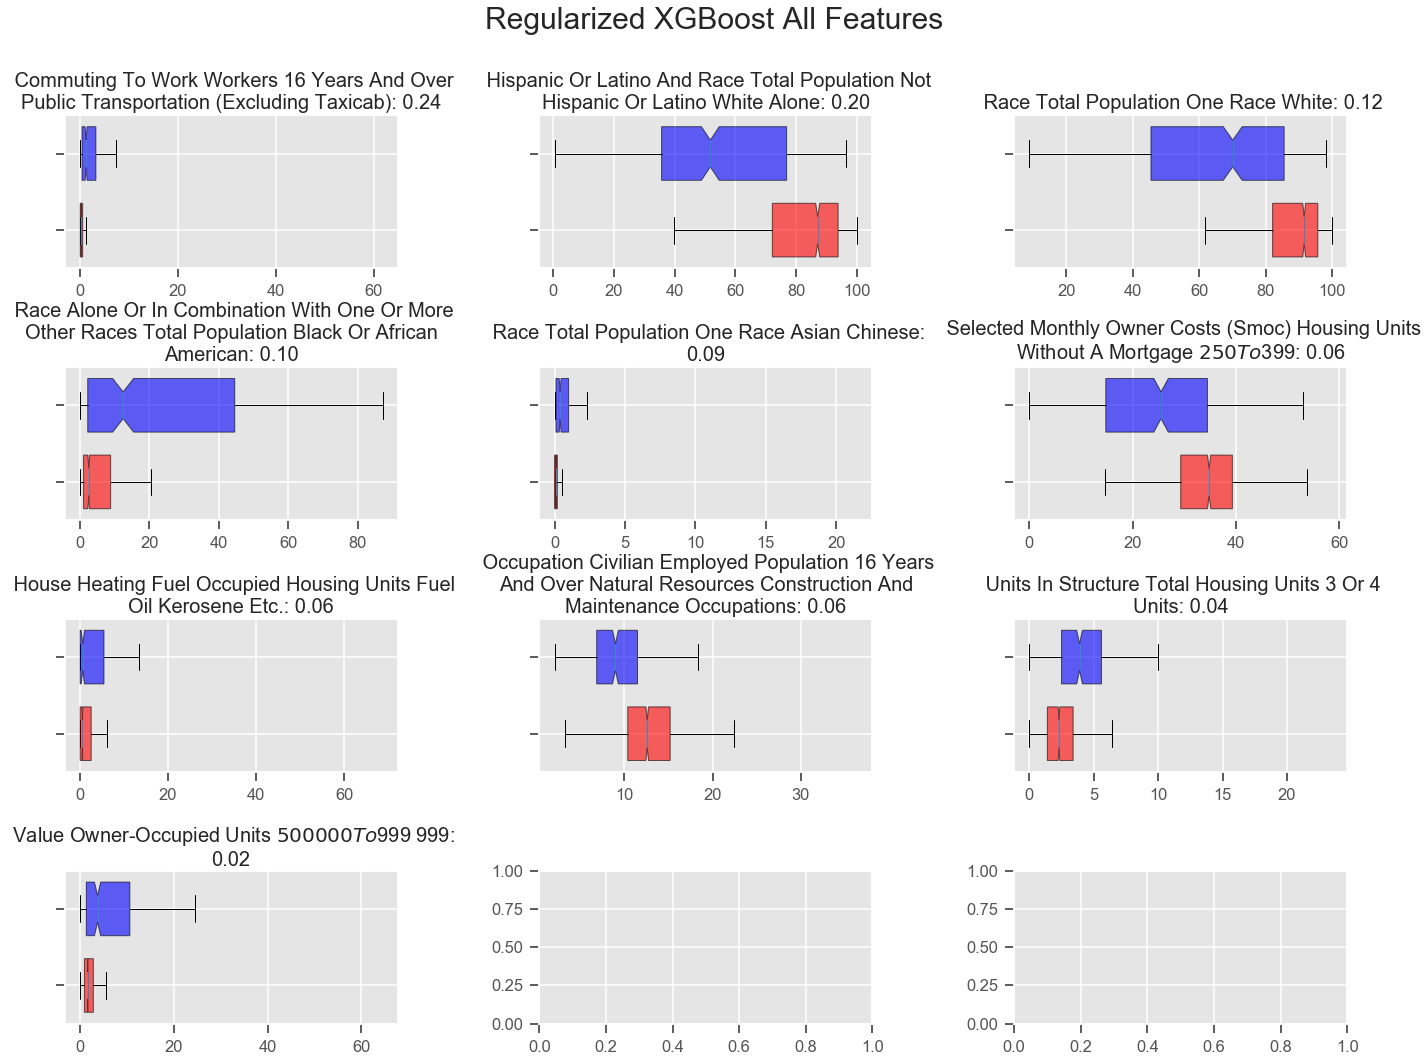

In [121]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))
fig.suptitle("Regularized XGBoost All Features", fontsize=30)
for i in range(10):
    bp = ax[i//3, i%3].boxplot([X.loc[y==1, xgc_feature_sets[
        xgc_reg_score.loc[
            xgc_reg_score.n_features<=10].sort_values(
            by="test", 
            ascending=False
        ).index[0]].index[i]], 
                                X.loc[y==0, xgc_feature_sets[
        xgc_reg_score.loc[
            xgc_reg_score.n_features<=10].sort_values(
            by="test", 
            ascending=False
        ).index[0]].index[i]]],
                               vert=False,
                               labels=["T", "H"],
                               notch=True, 
                               patch_artist=True,
                               widths=0.7
                              )
    for patch, color in zip(bp['boxes'], ["red", "blue"]):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

#     ax[i//4, i%4].set_xticklabels([])
    ax[i//3, i%3].set_yticklabels([])
    ax[i//3, i%3].set_title("\n".join(
        wrap(
            xgc_feature_sets[
                xgc_reg_score.loc[
                    xgc_reg_score.n_features<=10
                ].sort_values(
                    by="test", 
                    ascending=False
                ).index[0]
            ].label[i]+": "+"{:0.2f}".format(xgc_feature_sets[
                xgc_reg_score.loc[xgc_reg_score.n_features<=10
                                 ].sort_values(by="test", 
                                               ascending=False
                                              ).index[0]
            ].importance[i]
                                            ), 
            50
        )
    ),
                            fontsize=20
                           )
    
plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.savefig("images/xgc_features_reg_box")
plt.show()

In [122]:
xgc_trials = y
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.iloc[:, 2:])
    X_test_scaled = scaler.transform(X_test.iloc[:, 2:])
    xgc = XGBClassifier(verbose=False)
    xgc.fit(X_train_scaled, y_train)
    pred = pd.DataFrame(xgc.predict(X_test_scaled), index=X_test.index, columns=[i])

    xgc_trials = pd.merge(xgc_trials, pred, how="left", left_index=True, right_index=True)
    if (i+1)%100==0:
        print("progress: {}% done".format((i+1)/10))

progress: 0.0% done
progress: 10.0% done
progress: 20.0% done
progress: 30.0% done
progress: 40.0% done
progress: 50.0% done
progress: 60.0% done
progress: 70.0% done
progress: 80.0% done
progress: 90.0% done


In [134]:
xgc_trials.head()

,target,0,1,2,3,4,5,6,7,8,...,996,997,998,999,avg,diff,FIPS,trump,hillary,margin
0,1,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,1.0,1.000000,0.000000,1107,0.571788,0.416265,0.155523
1,0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,0.0,NaN,0.000000,0.000000,1119,0.246607,0.740290,-0.493683
2,0,NaN,0.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,0.0,NaN,0.614841,-0.614841,1073,0.443037,0.515706,-0.072668
3,1,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,1.000000,0.000000,1023,0.563083,0.426358,0.136725
4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,1.0,1.0,1.000000,0.000000,1059,0.786213,0.182475,0.603738


In [124]:
xgc_trials["avg"] = xgc_trials.iloc[:, 1:].mean(axis=1)
xgc_trials["diff"] = xgc_trials.target - xgc_trials.avg
xgc_trials["FIPS"] = df.FIPS
xgc_trials["trump"] = df.trump
xgc_trials["hillary"] = df.hillary
xgc_trials["margin"] = xgc_trials.trump - xgc_trials.hillary
xgc_trials["state"] = df.state

In [126]:
xgc_trials["diff"].max(), xgc_trials["diff"].min()

(1.0, -1.0)

In [ ]:
df.shape

In [ ]:
xgc_trials["diff"].shape

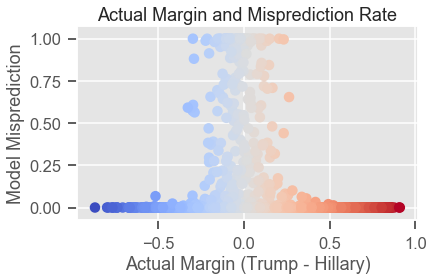

In [138]:
plt.scatter(xgc_trials.margin, 
            xgc_trials["diff"].apply(np.abs), 
            c=xgc_trials.margin, 
            cmap="coolwarm")
plt.xlabel("Actual Margin (Trump - Hillary)")
plt.ylabel("Model Misprediction")
plt.title("Actual Margin and Misprediction Rate")
plt.tight_layout()
plt.savefig("images/xgc_misprediction_margin")
plt.show()

In [137]:
swing_states = "Colorado, Florida, Iowa, Michigan, Minnesota, Ohio, Nevada, New Hampshire, North Carolina, Pennsylvania, Virginia, Wisconsin".split(", ")

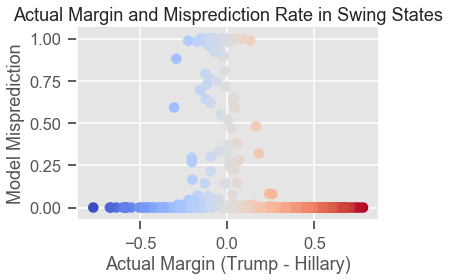

In [144]:
plt.scatter(xgc_trials.loc[(xgc_trials.state.isin(swing_states)), "margin"], 
            xgc_trials.loc[(xgc_trials.state.isin(swing_states)), "diff"].apply(np.abs), 
            c=xgc_trials.loc[(xgc_trials.state.isin(swing_states))].margin, 
            cmap="coolwarm")
plt.xlabel("Actual Margin (Trump - Hillary)")
plt.ylabel("Model Misprediction")
plt.title("Actual Margin and Misprediction Rate in Swing States")
plt.tight_layout()
plt.savefig("images/xgc_misprediction_margin_swing")
plt.show()

In [145]:
df_places = gpd.read_file('data/cbg.geojson')

In [162]:
df_places["FIPS"] = df_places.CensusBlockGroup.str[:5].astype(int)

In [153]:
county["FIPS"] = (county.state + county.county).astype(int)

In [158]:
county.head()

,NAME,state,county,FIPS
0,"Pickens County, Alabama",01,107,1107
1,"Sumter County, Alabama",01,119,1119
2,"Jefferson County, Alabama",01,073,1073
3,"Choctaw County, Alabama",01,023,1023
4,"Franklin County, Alabama",01,059,1059


In [163]:
county_poly = pd.merge(county, 
                       df_places[["FIPS", "geometry"]],  
                       on="FIPS", 
                       how="left")

In [164]:
county_poly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220333 entries, 0 to 220332
Data columns (total 5 columns):
NAME        220333 non-null object
state       220333 non-null object
county      220333 non-null object
FIPS        220333 non-null int64
geometry    220333 non-null object
dtypes: int64(1), object(4)
memory usage: 10.1+ MB


In [177]:
xgc_poly = pd.merge(county_poly, xgc_trials[["FIPS", "state", "diff", "trump", "margin"]], how="left", on="FIPS")

In [178]:
xgc_poly = gpd.GeoDataFrame(xgc_poly)

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


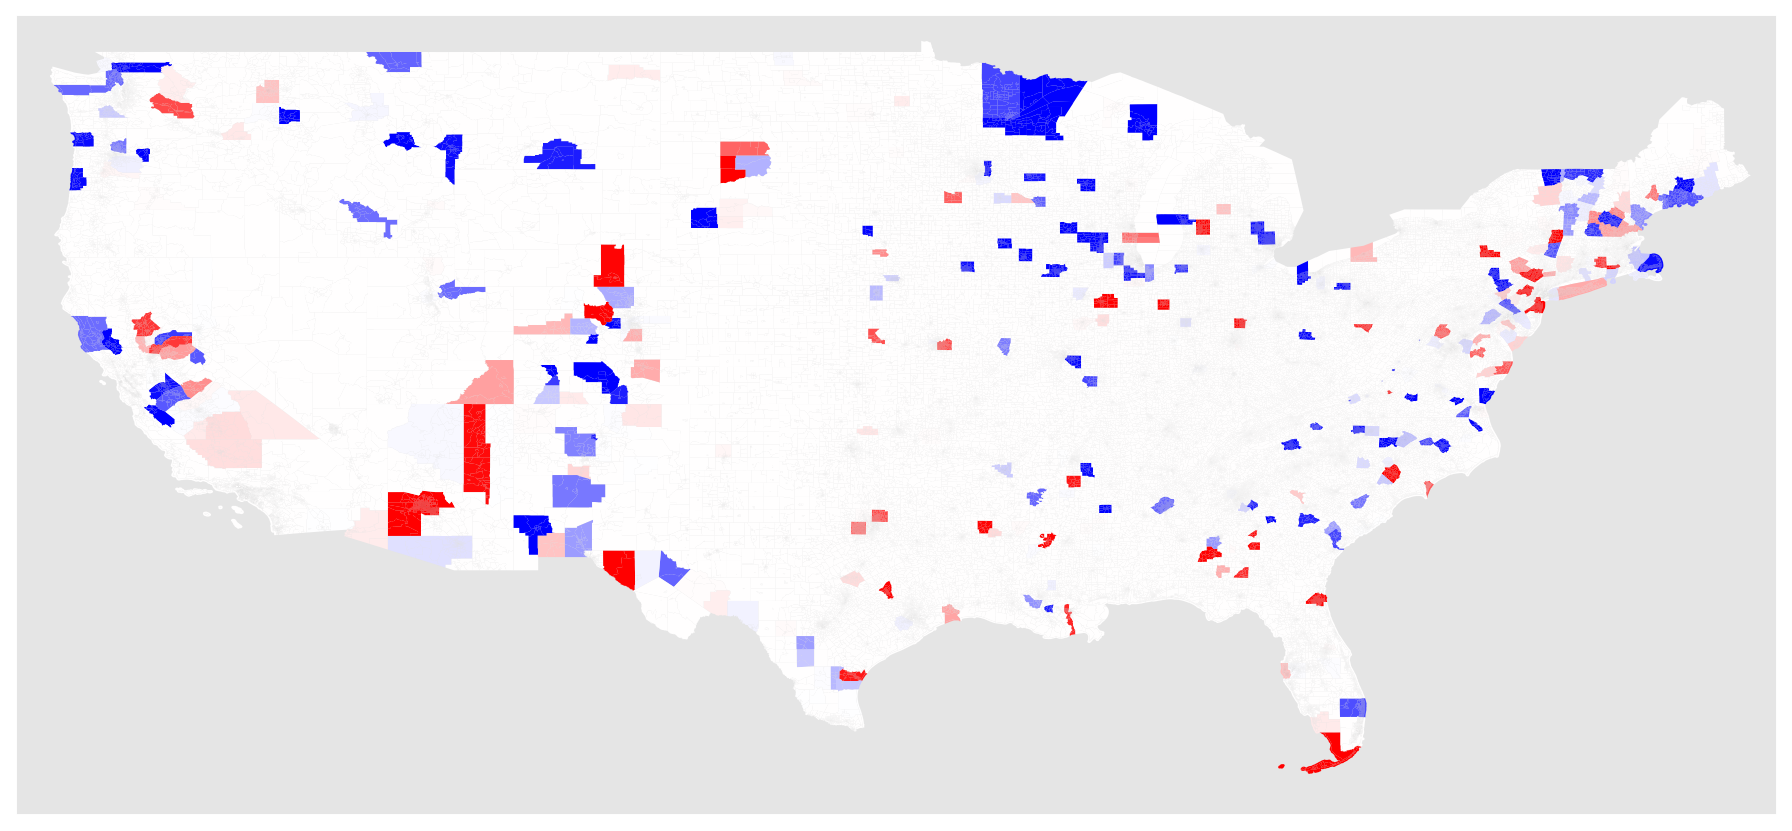

In [167]:
fig, ax = plt.subplots(1, figsize=(25, 12))
ax = xgc_poly.plot(column='diff', cmap='bwr', ax=ax)
ax.set_xlim([-126, -66])
ax.set_ylim([23, 50.25])
plt.xticks([], [])
plt.yticks([], [])
plt.tight_layout()
plt.savefig("images/xgc_diff_map")
plt.show()

In [168]:
mdv_poly = county_poly.loc[((county_poly.state=="11")|
                           (county_poly.state=="51")|
                           (county_poly.state=="24"))
                          ]

In [170]:
xgc_mdv_poly = pd.merge(mdv_poly, xgc_trials[["FIPS", "diff", "trump", "margin"]], how="left", on="FIPS")

In [171]:
xgc_mdv_poly = gpd.GeoDataFrame(xgc_mdv_poly)

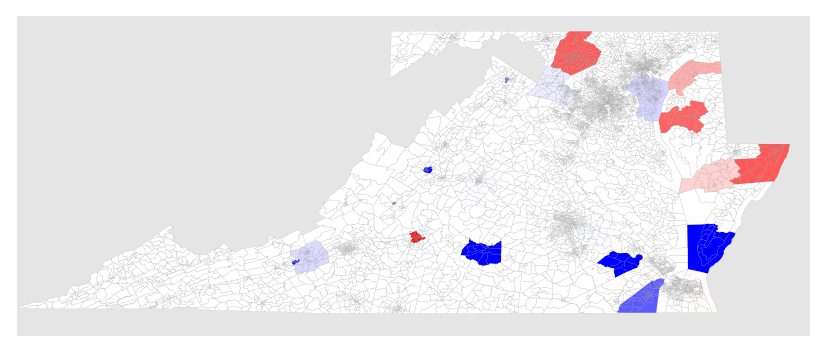

In [176]:
fig, ax = plt.subplots(1, figsize=(12, 5))
ax = xgc_mdv_poly.plot(column='diff', 
                       cmap='bwr', 
                       ax=ax,
                       linewidth=0.1, 
                       edgecolor="grey"
                      )
ax.set_xlim([-83.7, -74.75])
ax.set_ylim([36.28, 39.9])
plt.xticks([], [])
plt.yticks([], [])
plt.tight_layout()
plt.savefig("images/xgc_diff_map_dc")
plt.show()

In [183]:
xgc_poly.head()

,NAME,state_x,county,FIPS,geometry,state_y,diff,trump,margin
0,"Pickens County, Alabama",01,107,1107,(POLYGON ((-88.05802999998446 33.5277660004006...,Alabama,0.0,0.571788,0.155523
1,"Pickens County, Alabama",01,107,1107,(POLYGON ((-88.12121399992611 33.3661849999378...,Alabama,0.0,0.571788,0.155523
2,"Pickens County, Alabama",01,107,1107,(POLYGON ((-88.29300600002682 33.3829620001961...,Alabama,0.0,0.571788,0.155523
3,"Pickens County, Alabama",01,107,1107,(POLYGON ((-88.2530249999038 33.21150300016336...,Alabama,0.0,0.571788,0.155523
4,"Pickens County, Alabama",01,107,1107,(POLYGON ((-88.15581600020823 33.2788679995586...,Alabama,0.0,0.571788,0.155523


In [190]:
swing_state_FIPS = county.loc[county.NAME.apply(lambda x: x.split(", ")[1]).isin(swing_states), "state"]

In [184]:
swing_gdf_dict = {}
for state in swing_states:
    swing_gdf_dict[state] = gpd.GeoDataFrame(xgc_poly.loc[xgc_poly.state_y==state])

In [194]:
gis = GIS()

In [196]:
county_swing = county.loc[county.state.isin(swing_state_FIPS)]

In [ ]:
location_df = county_swing.NAME.apply(lambda x: geocode(x)[0]['location'])
county_swing["longitude"] = location_df.apply(lambda x: x["x"])
county_swing["latitude"] = location_df.apply(lambda x: x["y"])